In [1]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf

def create_dummy_wav(filename="test_audio.wav", duration=5, sr=22050):
    """
    Generates a dummy WAV file with varying amplitude for demonstration.
    It contains a sine wave that gets quiet in the middle.
    """
    print(f"Creating a dummy audio file: {filename}")
    # Generate a sine wave at 440 Hz (note 'A')
    t = np.linspace(0., duration, int(sr * duration))
    amplitude = np.ones_like(t)
    
    # Create a quiet section in the middle of the audio
    quiet_start_time = duration * 0.4
    quiet_end_time = duration * 0.6
    quiet_start_index = int(quiet_start_time * sr)
    quiet_end_index = int(quiet_end_time * sr)
    
    # Apply a fade out and fade in to make the transition smooth
    fade_len = int(0.1 * sr)
    amplitude[quiet_start_index - fade_len : quiet_start_index] = np.linspace(1, 0.1, fade_len)
    amplitude[quiet_start_index : quiet_end_index] = 0.1 # Low amplitude
    amplitude[quiet_end_index : quiet_end_index + fade_len] = np.linspace(0.1, 1, fade_len)

    # Generate the audio signal
    audio_data = amplitude * np.sin(2. * np.pi * 440. * t)
    
    # Write the data to a WAV file
    sf.write(filename, audio_data, sr)
    print("Dummy audio file created.")
    return filename, sr

def amplify_quiet_sections(y, sr, frame_length=2048, hop_length=512, energy_threshold=0.01, amplification_factor=5.0):
    """
    Amplifies sections of an audio signal that are below a certain energy threshold.
    
    Args:
        y (np.ndarray): The input audio time series.
        sr (int): The sample rate of y.
        frame_length (int): The number of samples in a frame.
        hop_length (int): The number of samples to advance between frames.
        energy_threshold (float): RMS energy level below which frames are amplified.
        amplification_factor (float): The factor by which to amplify quiet frames.
        
    Returns:
        np.ndarray: The audio time series with quiet sections amplified.
    """
    # Calculate Root-Mean-Square (RMS) energy for each frame
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    
    # Create a copy of the audio signal to modify
    y_amplified = y.copy()
    
    # Iterate through each frame
    for i in range(len(rms)):
        if rms[i] < energy_threshold:
            # Get the start and end sample for the current frame
            start_sample = i * hop_length
            end_sample = min(start_sample + frame_length, len(y_amplified))
            
            # Amplify the samples in this frame
            y_amplified[start_sample:end_sample] *= amplification_factor
            
    # Clip the audio to prevent distortion from values outside the [-1, 1] range
    y_amplified = np.clip(y_amplified, -1.0, 1.0)
    
    return y_amplified

def plot_spectrograms(S_original, S_amplified, sr):
    """
    Visualizes the original and amplified mel spectrograms side by side.
    """
    # Convert power spectrograms to decibels (dB) for better visualization
    S_db_original = librosa.power_to_db(S_original, ref=np.max)
    S_db_amplified = librosa.power_to_db(S_amplified, ref=np.max)

    # Create figure
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 8))
    fig.suptitle('Mel Spectrogram Comparison', fontsize=16)

    # Plot original spectrogram
    img1 = librosa.display.specshow(S_db_original, sr=sr, x_axis='time', y_axis='mel', ax=ax[0])
    ax[0].set(title='Original Spectrogram')
    ax[0].label_outer() # Hide x-axis label for the top plot
    fig.colorbar(img1, ax=ax[0], format='%+2.0f dB')

    # Plot amplified spectrogram
    img2 = librosa.display.specshow(S_db_amplified, sr=sr, x_axis='time', y_axis='mel', ax=ax[1])
    ax[1].set(title='Spectrogram with Amplified Quiet Sections')
    fig.colorbar(img2, ax=ax[1], format='%+2.0f dB')

    # Adjust layout and display the plot
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle
    plt.show()



In [3]:
# 1. Define the audio file to load
# <<< IMPORTANT: Change this path to your WAV file. >>>
wav_file = "2086-149220-0033.wav" 

# To generate the dummy file for a first run, uncomment the following line:
# create_dummy_wav()

# 2. Load the audio file
print(f"Loading audio file: {wav_file}")
try:
    y, sr = librosa.load(wav_file, sr=None) # sr=None to preserve original sample rate
except FileNotFoundError:
    print(f"\nERROR: File not found at '{wav_file}'")
    print("Please make sure the file path is correct.")
    print("If you're using the default 'test_audio.wav', uncomment the 'create_dummy_wav()' line and run this script again to generate it.\n")
except Exception as e:
    print(f"Error loading audio file: {e}")

Loading audio file: 2086-149220-0033.wav


In [4]:
# 3. Calculate the first mel spectrogram (Original)
print("Calculating original mel spectrogram...")
S_original = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512)

Calculating original mel spectrogram...


In [5]:
# 4. Amplify small/quiet sections of the audio data
print("Amplifying quiet audio sections...")
y_amplified = amplify_quiet_sections(y, sr)

Amplifying quiet audio sections...


In [6]:
# Save the amplified audio to a new file (optional)
sf.write("amplified_audio.wav", y_amplified, sr)
print("Saved amplified audio to amplified_audio.wav")

Saved amplified audio to amplified_audio.wav


In [7]:
# 5. Calculate the second mel spectrogram (Amplified)
print("Calculating mel spectrogram for amplified audio...")
S_amplified = librosa.feature.melspectrogram(y=y_amplified, sr=sr, n_fft=2048, hop_length=512)

Calculating mel spectrogram for amplified audio...


Visualizing spectrograms...


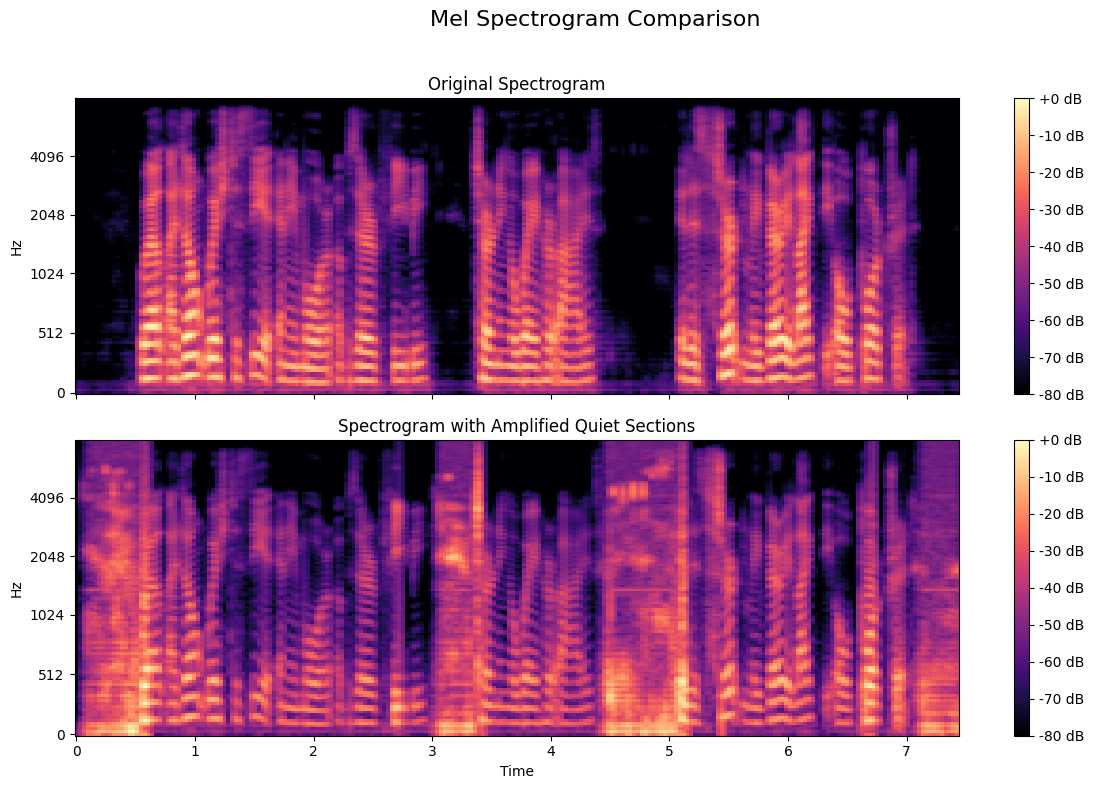

In [8]:
# 6. Visualize both spectrograms for comparison
print("Visualizing spectrograms...")
plot_spectrograms(S_original, S_amplified, sr)